In [1]:
from rdkit import Chem
import pandas as pd
from IPython.display import clear_output
from IPython.display import  display
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

### Smiles generation

In [2]:
# Handout 3 hint:
# The class workes with atom indices and not with atom objects
# For the Molecule class you can work with atom objects directly
# and use them as keys of dictionaries for example
# Alternatively, you could assign indices to Atom objects using a dictionary
# Once you modified the class, you could use it in class Molecule the following way:
# class Molecule:
#     ...
#     def to_simple_smiles(self):
#         sm = SmilesMaker()
#         ranking = cangen_ranking(self)
#         return sm.getSimpleSmiles(self,ranking)

In [3]:
from collections import defaultdict
from heapq import heapify,heappush,heappop

class SmilesMaker:
    
    def __init__(self,rankingMethod= None):

        self.rankingMethod = rankingMethod
        
        # fields used during Smiles generation
        self.atomRanks = None
        self.visited = None
        self.ancestor = None
        self.openingClosures = None
        self.closingClosures = None
        self.digits = None
        self.ranks = None
        
    @staticmethod
    def _getBondSymbol(mol,a,b):
            "return bond symbol between atoms a and b"
            bond = mol.GetBondBetweenAtoms(a,b)
            b = bond.GetBondTypeAsDouble()
            if b==1.0: return ""
            if b==1.5: return ""
            if b==2.0: return "="
            if b==3.0: return "#"        
    
    
    def getSimpleSmiles(self, mol,ranks=defaultdict(lambda: 0)):
        """
        return a simplified version of Smiles
        mol is assumed not to contain individual hydrogen atom objects
        multiple fragment Smiles are not supported
        optional parameter ranks defines the priorities of atom ranks
        """    
        # atom prioritization
        if not ranks:
            if self.rankingMethod:
                self.atomRanks = self.rankingMethod(mol)
            else:
                self.atomRanks = defaultdict(lambda: 0)
        else:
            self.atomRanks = ranks

        # retrieve root atom with highest priority
        atoms = sorted([a.GetIdx() for a in mol.GetAtoms()],key=lambda a: self.atomRanks[a])
        root = atoms[0]

        # keep track of visited atoms
        self.visited=set()
        # keep track of ancestor atoms
        self.ancestor=set()
        # key: atom to be opened, values: closing atoms
        self.openingClosures=defaultdict(lambda: [])
        self.getClosures(mol,root,None)

        # key: atom to be closed, values: bond symbol + closure numbers
        self.closingClosures=defaultdict(lambda: [])
        # list of digits available for closures (only single digits supported)
        # heap operqations are used on digits to always retrieve
        # the smallest digit available
        
        # Only support closure digits from 1 to 9
        self.digits = [str(x) for x in range(1,10)]
        # no need to call heapify as a sorted list fulfills the heap property

        self.visited = set() # reset visited atoms
        return self.buildSmiles(mol,root,None)


    def getClosures(self,mol,atom,parent):
        self.ancestor.add(atom) # not every visited atom is ancestor
        self.visited.add(atom)
        atomObj = mol.GetAtomWithIdx(atom)
        nbors = [a.GetIdx() for a in atomObj.GetNeighbors() if a.GetIdx()!=parent]
        nbors.sort(key=lambda a: self.atomRanks[a])
        for n in nbors:
            if n in self.ancestor:
                self.openingClosures[n].append(atom)
            elif n not in self.visited:
                self.getClosures(mol,n,atom)
        self.ancestor.remove(atom)
  
    def buildSmiles(self,mol,atom,parent):
        self.visited.add(atom)
        # Each call constructs a partial Smiles starting with
        # bond symbol + atom symbol
        # Only the root atom has no preceding bond symbol
        seq = ""
        if parent is not None:
            seq += self._getBondSymbol(mol,parent,atom)
        atomObj = mol.GetAtomWithIdx(atom)
        symbol = atomObj.GetSymbol()
        if atomObj.GetIsAromatic():
            symbol = symbol.lower()
            # Check special case aromatic N + H use '[nH]' instead of 'n'
        seq += symbol 

        # add ring closure closers
        for d in self.closingClosures[atom]:
            seq += d
            # The digit is freed and can be used again
            heappush(self.digits,d[-1])
        # add ring closure openers
        for a in self.openingClosures[atom]:
            # a new digit is taken from digits
            d = self._getBondSymbol(mol,atom,a)+str(heappop(self.digits))
            seq += d
            self.closingClosures[a].append(d)

        nbors = [a.GetIdx() for a in atomObj.GetNeighbors() if a.GetIdx()!=parent]
        nbors.sort(key=lambda a: self.atomRanks[a])
        branches = [] # Smiles for all branches
        for n in nbors:
            if n not in self.visited:
                branches.append(self.buildSmiles(mol,n,atom))
        # The first branches have to be parenthesized
        for branch in branches[:-1]:
            seq += "("+branch+")"
        # tha last (i.e. main) branch does not get parentheses
        if len(branches)>0:
            seq += branches[-1]
        return seq

        

In [4]:
sm=SmilesMaker()
m=Chem.MolFromSmiles("Oc1ccccc1")
sm.getSimpleSmiles(m)

'Oc1ccccc1'

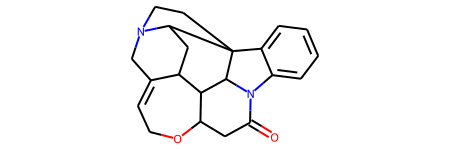

In [5]:
strychnin = Chem.MolFromSmiles("O=C7N2c1ccccc1[C@@]64[C@@H]2[C@@H]3[C@@H](OC/C=C5\[C@@H]3C[C@@H]6N(CC4)C5)C7")
Chem.RemoveStereochemistry(strychnin)
strychnin

O=C1N2c3ccccc3C34C2C2C(OCC=C5C2CC4N(CC3)C5)C1


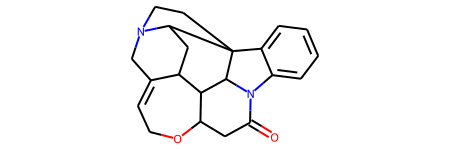

In [6]:
mysmiles=sm.getSimpleSmiles(strychnin)
print(mysmiles)
Chem.MolFromSmiles(mysmiles)

In [7]:
Chem.MolToSmiles(Chem.MolFromSmiles(mysmiles))

'O=C1CC2OCC=C3CN4CCC56c7ccccc7N1C5C2C3CC46'

### Morgan Algorithm

In [8]:
# Handout 3
# You do not need to adapt the Morgan algorithm
# Only the Cangen algorithm

In [9]:
def morgan_iter(ranks,mol):
    new_ranks = {}
    for atom_idx in ranks.keys():
        atom = mol.GetAtomWithIdx(atom_idx)
        new_val = sum(ranks[a.GetIdx()] for a in atom.GetNeighbors())
        new_ranks[atom_idx] = new_val
    return new_ranks

def morgan(mol):
    ranks = {a.GetIdx():a.GetDegree() for a in mol.GetAtoms()}
    best_ranks = ranks
    best_value_count = len(set(best_ranks.values()))
    no_improvement_count = 0
    while no_improvement_count < 3:
        ranks = morgan_iter(ranks,mol)
        value_count = len(set(ranks.values()))
        if value_count > best_value_count:
            best_ranks = ranks
            best_value_count = value_count
            no_improvement_count = 0
        else:
            no_improvement_count += 1
    for k in best_ranks:
        best_ranks[k] = -best_ranks[k]
    return best_ranks

In [10]:
sm=SmilesMaker(morgan)

In [11]:
mysmiles=sm.getSimpleSmiles(strychnin)
mysmiles
#morgan(strychnin)

'C123C4C5C6CC1N(CC2)CC6=CCOC5CC(N4c1c3cccc1)=O'

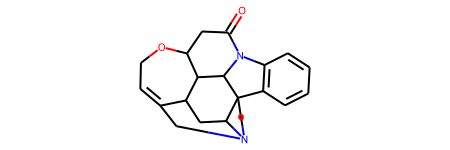

In [12]:
Chem.MolFromSmiles(mysmiles)

In [13]:
m=Chem.MolFromSmiles("O=C(C)Oc1ccccc1C(=O)O")
sm.getSimpleSmiles(m)

'c1(c(OC(=O)C)cccc1)C(=O)O'

### Cangen Algorithm

In [14]:
import math

def checkPrime(v):
    "check whether v is prime"
    limit = int(math.sqrt(v))+1
    for d in range(3,limit,2):
        if v%d==0:
            return False
    return True

def getPrimeList(numPrimes):
    "Retrieve a list of numPrimes primes"
    pl = [0,2]
    n = 3
    while len(pl)<numPrimes:
        if checkPrime(n):
            pl.append(n)
        n += 2
    return pl

primes = getPrimeList(1000)

In [15]:
def invariants(mol):
    "Determine initial atom invariants"
    inv = dict()
    for atom in mol.GetAtoms():
        i1 = atom.GetDegree()
        i2 = atom.GetTotalValence()-atom.GetTotalNumHs()
        i3 = atom.GetAtomicNum()
        i4 = 1 if atom.GetFormalCharge() < 0 else 0
        i5 = abs(atom.GetFormalCharge())
        i6 = atom.GetTotalNumHs()
        inv[atom.GetIdx()] = int("%1d%02d%02d%1d%1d%1d"%(i1,i2,i3,i4,i5,i6))
    return inv

In [16]:
def invToRanks(inv,oldRanks):
    """Convert invariant to ranks consistent with ranking of oldRanks
       return rmap of ranks and the number of different ranks
    """
    sortedAtoms = sorted(inv.keys(),key=lambda atom: (oldRanks[atom],inv[atom]))
    # When assigning ranks to the sorted atoms treat ties properly
    rk = 0
    prev = -1
    ranks = dict()
    for a in sortedAtoms:
        if (oldRanks[a],inv[a]) != prev:
            rk+=1
            prev = (oldRanks[a],inv[a]) 
        ranks[a] = rk
    return ranks,rk

In [17]:
# The CangenTrace class was written to enable going through the algorithm step by step
# and show intermediate results in a table
# Of course, this is not necessary for handout 3
# See below for an implementation as a function that can be called
# ranking = cangen_ranking(mol)

In [18]:
def new_ranks(mol,ranks):
    "Calculate a new set of ranks from old ranks"
    atom_primes = {}
    for a in mol.GetAtoms():
        i = a.GetIdx()
        atom_primes[i]=primes[ranks[i]]
    inv = dict()
    for a in mol.GetAtoms():
        prod = 1
        for n in a.GetNeighbors():
            prod *= atom_primes[n.GetIdx()]
        inv[a.GetIdx()] = prod
    return invToRanks(inv,ranks)

def canon_iter(mol,ranks):
    old_rank_count = 0
    rank_count = 1
    while old_rank_count < rank_count and rank_count < len(ranks):
        old_rank_count = rank_count
        ranks,rank_count = new_ranks(mol,ranks)
    return ranks,rank_count

def break_ties(mol,ranks):
    "break a some tied ranks"
    rankCount = [0]*len(ranks)
    for r in ranks.values():
        rankCount[r] += 1

    # find smallest duplicate rank (rj)
    rk=0
    while rankCount[rk] <= 1:
        rk += 1

    inv = dict() # new invariants
    for a in ranks.keys():
        inv[a] = 2*ranks[a]

    # change invariant of one of the smallest duplicate ranks
    for a in ranks.keys():
        if ranks[a] == rk:
            inv[a] -= 1
            break
    return invToRanks(inv,ranks)

def cangen_ranking(mol):
    inv = invariants(mol)
    ranks,rank_count = invToRanks(inv,[1]*len(inv))
    while rank_count < len(ranks):
        ranks,rank_count = canon_iter(mol,ranks)
        if rank_count < len(ranks):
            ranks,rank_count = break_ties(mol,ranks)
    return ranks

In [19]:
ranking=cangen_ranking(strychnin)

In [20]:
SmilesMaker().getSimpleSmiles(strychnin,ranking)

'O=C1CC2OCC=C3CN4CCC56C4CC3C2C6N1c1ccccc51'

In [21]:
m=Chem.MolFromSmiles("CC1=CC(=O)C(=O)N1")
SmilesMaker().getSimpleSmiles(m,cangen_ranking(m))

'CC=1NC(=O)C(=O)C=1'

In [22]:
cubane = Chem.MolFromSmiles("C12C3C4C1C5C2C3C45")
SmilesMaker().getSimpleSmiles(cubane,cangen_ranking(cubane))

'C12C3C4C1C1C2C3C41'

In [23]:
class CangenTrace:
    def __init__(self,simpleLabels=False):
        self.simpleLabels=simpleLabels
        self.trace = None
        
        self.mol = None
        self.ranked_mol = None
        self.labels = None
        self.nbors = None
        self.ranks = None
        self.rankCount = None
        self.step = 0
        self.img_size_x = 250
        self.img_size_y = 250
        
    def add_labels(self):
        self.labels={}
        for a in self.mol.GetAtoms():
            self.labels[a.GetIdx()]=chr(ord('a')+a.GetIdx())
        for a in self.mol.GetAtoms():
            lbl = '%s:%s'%(a.GetSymbol(),self.labels[a.GetIdx()]) if not self.simpleLabels else self.labels[a.GetIdx()]
            a.SetProp('atomLabel',lbl)
        self.trace['lbl']=pd.Series(self.labels)
    
    def add_ranks(self):
        for a in self.ranked_mol.GetAtoms():
            lbl = '%s:%s'%(a.GetSymbol(),self.ranks[a.GetIdx()]) if not self.simpleLabels else str(self.ranks[a.GetIdx()])
            a.SetProp('atomLabel',lbl)

    def add_nbor_labels(self):
        self.nbors={}
        for a in self.mol.GetAtoms():
            self.nbors[a.GetIdx()]="".join(self.labels[n.GetIdx()] for n in a.GetNeighbors())
        self.trace['nbors']=pd.Series(self.nbors)

    def break_ties(self):
        "break a some tied ranks"

        # count how often each rank occurs
        rankCount = [0]*len(self.ranks)
        for r in self.ranks.values():
            rankCount[r] += 1

        # find smallest duplicate rank (rj)
        rk=0
        while rankCount[rk] <= 1:
            rk += 1

        inv = dict() # new invariants
        for a in self.ranks.keys():
            inv[a] = 2*self.ranks[a]

        # change invariant of one of the smallest duplicate ranks
        for a in self.ranks.keys():
            if self.ranks[a] == rk:
                inv[a] -= 1
                break
        self.trace[f'BT-Inv.{self.step}'] = pd.Series(inv)
        yield f'Step {self.step}: break ties invariants'
        old_ct = self.rankCount
        self.ranks,self.rankCount = invToRanks(inv,self.ranks)
        self.trace[f'Rk.{self.step}'] = pd.Series(self.ranks)
        self.add_ranks()
        improve_msg=f", rank count improved by {self.rankCount-old_ct}"
        if self.rankCount==old_ct:
            improve_msg=f"rank count did not improve: Breaking of ties required"
        yield f'Step {self.step}: break ties invariants -> ranks,  rank count: {self.rankCount}'
        self.step += 1

    def new_ranks(self):
        "Calculate a new set of ranks from old ranks"
        atom_primes = {}
        for a in self.mol.GetAtoms():
            i = a.GetIdx()
            atom_primes[i]=primes[self.ranks[i]]
        self.trace[f'Pr.{self.step}'] = pd.Series(atom_primes)
        yield f'Step {self.step}: ranks -> primes'
        inv = dict()
        for a in self.mol.GetAtoms():
            prod = 1
            for n in a.GetNeighbors():
                prod *= atom_primes[n.GetIdx()]
            inv[a.GetIdx()] = prod
        self.trace[f'Inv.{self.step}'] = pd.Series(inv)
        yield f'Step {self.step}: new invariants'
        old_ct = self.rankCount
        self.ranks,self.rankCount = invToRanks(inv,self.ranks)
        self.trace[f'Rk.{self.step}'] = pd.Series(self.ranks)
        self.add_ranks()
        improve_msg=f", rank count improved by {self.rankCount-old_ct}"
        if self.rankCount==old_ct:
            improve_msg=f"rank count did not improve: Breaking of ties required"
        yield f'Step {self.step}: invariants -> ranks, rank count: {self.rankCount}'+improve_msg
        

    def canon_iter(self):
        oldRankCount = 0
        while oldRankCount < self.rankCount and self.rankCount < len(self.ranks):
            oldRankCount = self.rankCount
            for msg in self.new_ranks():
                yield msg
            self.step += 1

    def display_mol(self):
        display(Draw.MolsToGridImage((self.mol,self.ranked_mol),subImgSize=(self.img_size_x,self.img_size_y)))
        
    def rank_mol_trace(self,mol):
        self.mol = mol
        self.ranked_mol=Chem.Mol(mol)
        self.trace = pd.DataFrame(None,list(map(lambda x: x.GetIdx(),mol.GetAtoms())))
        self.add_labels()
        self.add_nbor_labels()
        yield 'labeling'
        inv = invariants(mol)
        self.trace['ini.Inv.']=pd.Series(inv)
        yield 'Initial'
        self.ranks,self.rankCount = invToRanks(inv,[1]*len(inv))
        self.trace['Ranks0']=pd.Series(self.ranks)
        self.add_ranks()
        yield f'Step 0: Initial ranks, rank count: {self.rankCount}'
        self.step = 1
        while self.rankCount<len(self.ranks):
            for msg in self.canon_iter():
                yield msg
            if self.rankCount<len(self.ranks):
                for ms in self.break_ties():
                    yield msg
        yield "Done"

    

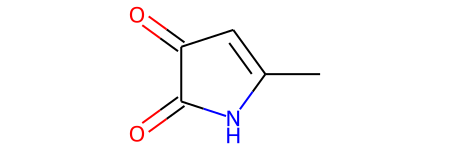

In [24]:
ct = CangenTrace()
m=Chem.MolFromSmiles("CC1=CC(=O)C(=O)N1")
m

Done


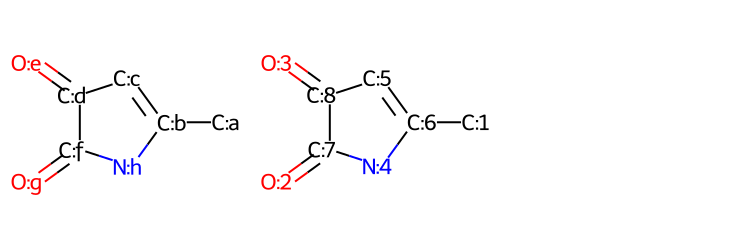

lbl nbors  ini.Inv.  Ranks0  Pr.1  Inv.1  Rk.1  Pr.2  Inv.2  Rk.2
0   a     b  10106003       1     2     11     1     2     11     1
1   b   ach  30406000       5    11     70     5    11     70     6
2   c    bd  20306001       4     7    121     4     7    187     5
3   d   cef  30406000       5    11    231     7    17    273     8
4   e     d  10208000       2     3     11     2     3     17     3
5   f   dgh  30406000       5    11    165     6    13    255     7
6   g     f  10208000       2     3     11     2     3     13     2
7   h    fb  20207001       3     5    121     3     5    143     4

'CC=1NC(=O)C(=O)C=1'

In [25]:
for s in ct.rank_mol_trace(m):
    clear_output()
    print(s)
    #display(ct.mol)
    ct.display_mol()
    display(ct.trace)
    input()
print()
sm=SmilesMaker()
sm.getSimpleSmiles(m,ct.ranks)

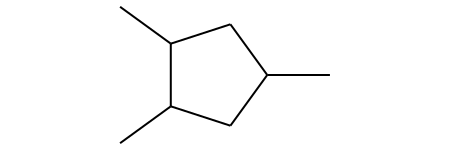

In [26]:

m=Chem.MolFromSmiles("CC1CC(C)C(C)C1")
m

Done


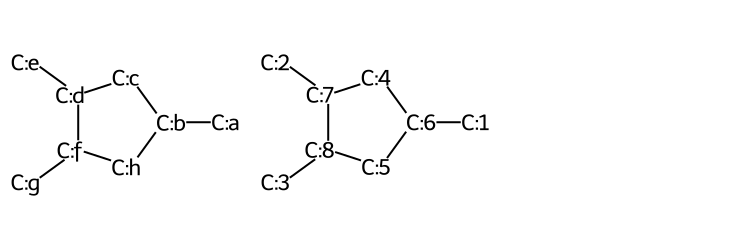

lbl nbors  ini.Inv.  Ranks0  Pr.1  Inv.1  Rk.1  Pr.2  Inv.2  Rk.2  ...  \
0   a     b  10106003       1     2      5     1     2      5     1  ...   
1   b   ach  30306001       3     5     18     3     5     18     4  ...   
2   c    bd  20206002       2     3     25     2     3     35     3  ...   
3   d   cef  30306001       3     5     30     4     7     42     5  ...   
4   e     d  10106003       1     2      5     1     2      7     2  ...   
5   f   dgh  30306001       3     5     30     4     7     42     5  ...   
6   g     f  10106003       1     2      5     1     2      7     2  ...   
7   h    fb  20206002       2     3     25     2     3     35     3  ...   

   Inv.3  Rk.3  BT-Inv.4  Rk.4  Pr.5  Inv.5  Rk.5  Pr.6  Inv.6  Rk.6  
0      7     1         2     1     2     11     1     2     11     1  
1     50     4         8     5    11     98     5    11     98     6  
2     77     3         6     4     7    143     4     7    143     4  
3    165     5        10     6    13    273     6    13    357     7  
4     11     2         3     2     3     13     2     3     13     2  
5    165     5        10     6    13    455     7    17    455     8  
6     11     2         4     3     5     13     3     5     17     3  
7     77     3         6     4     7    143     4     7    187     5  

[8 rows x 21 columns]

'CC1CC(C)C(C)C1'

In [27]:
for s in ct.rank_mol_trace(m):
    clear_output()
    print(s)
    #display(ct.mol)
    ct.display_mol()
    display(ct.trace)
    input()
print()
sm=SmilesMaker()
sm.getSimpleSmiles(m,ct.ranks)

Done


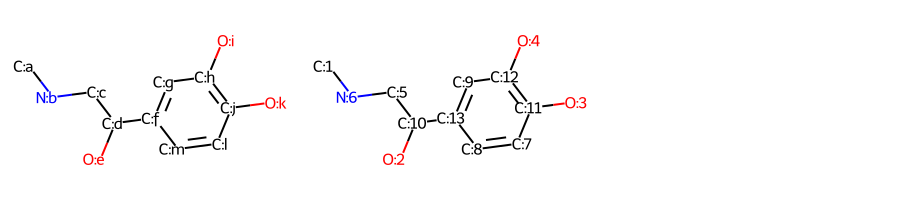

lbl nbors  ini.Inv.  Ranks0  Pr.1  Inv.1  Rk.1  Pr.2  Inv.2  Rk.2  Pr.3  \
0    a     b  10106003       1     2      7     1     2     11     1     2   
1    b    ac  20207001       4     7     10     5    11     14     5    11   
2    c    bd  20206002       3     5     91     4     7    209     4     7   
3    d   cef  30306001       6    13    255     8    19    609     9    23   
4    e     d  10108001       2     3     13     2     3     19     2     3   
5    f   dgm  30406000       7    17   1573    10    29   4199    12    37   
6    g    fh  20306001       5    11    289     7    17    667     8    19   
7    h   gij  30406000       7    17    561     9    23   1955    11    31   
8    i     h  10108001       2     3     17     3     5     23     3     5   
9    j   hkl  30406000       7    17    561     9    23   1495    10    29   
10   k     j  10108001       2     3     17     3     5     23     3     5   
11   l    jm  20306001       5    11    187     6    13    299     6    13   
12   m    lf  20306001       5    11    187     6    13    377     7    17   

    Inv.3  Rk.3  
0      11     1  
1      14     6  
2     253     5  
3     777    10  
4      23     2  
5    7429    13  
6    1147     9  
7    2755    12  
8      31     4  
9    2015    11  
10     29     3  
11    493     7  
12    481     8



CNCC(O)c1ccc(O)c(O)c1


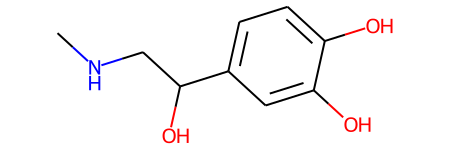

In [28]:
ct.img_size_x=300
ct.img_size_y=200
m= Chem.MolFromSmiles("CNCC(O)c1cc(O)c(O)cc1")
for s in ct.rank_mol_trace(m):
    clear_output()
    print(s)
    #display(ct.mol)
    ct.display_mol()
    display(ct.trace)
    input()
print()
sm=SmilesMaker()
smi=sm.getSimpleSmiles(m,ct.ranks)
print(smi)
Chem.MolFromSmiles(smi)

Done


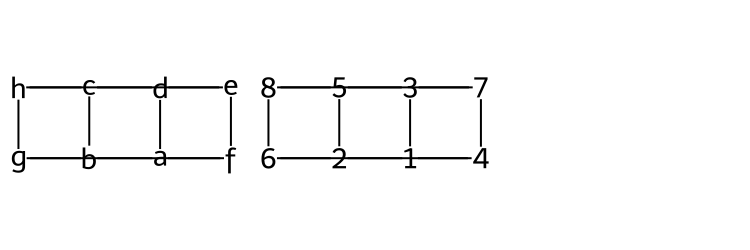

lbl nbors  ini.Inv.  Ranks0  Pr.1  Inv.1  Rk.1  BT-Inv.2  Rk.2  Pr.3  ...  \
0   a   bdf  30306001       1     2      8     1         1     1     2  ...   
1   b   acg  30306001       1     2      8     1         2     2     3  ...   
2   c   bdh  30306001       1     2      8     1         2     2     3  ...   
3   d   cea  30306001       1     2      8     1         2     2     3  ...   
4   e   dfh  30306001       1     2      8     1         2     2     3  ...   
5   f   ega  30306001       1     2      8     1         2     2     3  ...   
6   g   fhb  30306001       1     2      8     1         2     2     3  ...   
7   h   gce  30306001       1     2      8     1         2     2     3  ...   

   Inv.7  Rk.7  Pr.8  Inv.8  Rk.8  BT-Inv.9  Rk.9  Pr.10  Inv.10  Rk.10  
0     75     1     2     75     1         2     1      2     105      1  
1     98     2     3     98     2         4     2      3     242      2  
2    165     4     7    195     4         8     5     11     255      5  
3     98     3     5    154     3         5     3      5     286      3  
4    275     5    11    325     5        10     6     13     595      7  
5     98     3     5    154     3         6     4      7     286      4  
6    165     4     7    195     4         8     5     11     357      6  
7    343     6    13    539     6        12     7     17    1573      8  

[8 rows x 31 columns]



C12C3C4C1C1C2C3C41


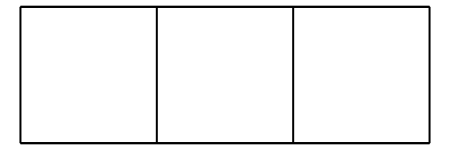

In [29]:
from rdkit.Chem.Draw.MolDrawing import MolDrawing
cubane = Chem.MolFromSmiles("C12C3C4C1C5C2C3C45")
#cubane = next(Chem.SDMolSupplier("cubane2.mol"))
print(cubane)
ct=CangenTrace(simpleLabels=True)
for s in ct.rank_mol_trace(cubane):
    clear_output()
    print(s)
    #display(ct.mol)
    ct.display_mol()
    display(ct.trace)
    input()
print()
sm=SmilesMaker()
smi=sm.getSimpleSmiles(cubane,ct.ranks)
print(smi)
Chem.MolFromSmiles(smi)